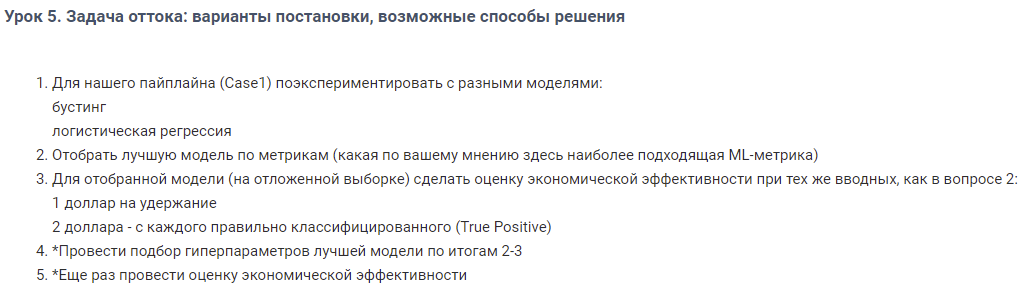

## 1

In [15]:
data_url = 'https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91'

In [13]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('churn_data.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
del df['CustomerId']
df.head()

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Посмотрим на распределение классов:

In [6]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Примерно 2:8 или 1 к 4

Построим модель. Сразу же будем работать с использованием sklearn pipeline

In [7]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [8]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [9]:
df.head()

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Зададим списки признаков

In [10]:
nominative_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Создадим трансформер и объединим их в список.

In [11]:
final_transformers = list()

for cat_col in nominative_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [ ]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модели LogisticRegression RandomForestClassifier XGBoost GradientBoostingClassifier

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

xgb.set_config(verbosity=0)

In [62]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

Обучим модель

In [40]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [41]:
# наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [42]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.38, F-Score=0.641, Precision=0.653, Recall=0.629


Отрисуем матрицу ошибок

In [54]:
# Вычислим матрицу ошибок
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
cnf_matrix

array([[1832,  159],
       [ 195,  314]], dtype=int64)

In [58]:
def take_model(X_train, X_test, y_train, type_model, data_feats):
    '''Функция рассчета predict  для различных моделей '''
    
    classifier = Pipeline([
        ('features', data_feats),
        ('classifier', type_model(random_state=42)),
    ])

    # обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    predict = classifier.predict_proba(X_test)[:, 1]
    
    return predict

In [95]:
def calculate_metrics(model_predict):
    '''Функция рассчета метрик для различных моделей'''
    
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, model_predict)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_test, model_predict)
#     print(f'Best Threshold={round(thresholds[ix],3)}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}, ROC AUC={roc_auc} ')
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

In [96]:
# Для  LogisticRegression
print('Для  LogisticRegression')
model_LogReg_predict = take_model(X_train, X_test, y_train, LogisticRegression, feats)
calculate = calculate_metrics(model_LogReg_predict)
print(f'Best Threshold={round(calculate[0],3)}, F-Score={round(calculate[1],3)}, Precision={round(calculate[2],3)}, Recall={round(calculate[3],3)}, ROC AUC={round(calculate[4],3)}') 
print('----'*5)

print('Для  RandomForestClassifier')
model_RandomForestClassifier = take_model(X_train, X_test, y_train, RandomForestClassifier, feats)
calculate = calculate_metrics(model_RandomForestClassifier)
print(f'Best Threshold={round(calculate[0],3)}, F-Score={round(calculate[1],3)}, Precision={round(calculate[2],3)}, Recall={round(calculate[3],3)}, ROC AUC={round(calculate[4],3)}') 
print('----'*5)

print('Для  XGBoost')
model_XGB_predict = take_model(X_train, X_test, y_train, xgb.XGBClassifier, feats)
calculate = calculate_metrics(model_XGB_predict)
print(f'Best Threshold={round(calculate[0],3)}, F-Score={round(calculate[1],3)}, Precision={round(calculate[2],3)}, Recall={round(calculate[3],3)}, ROC AUC={round(calculate[4],3)}') 
print('----'*5)

print('Для  GRBoost')
model_GRBoost_predict = take_model(X_train, X_test, y_train, GradientBoostingClassifier, feats)
calculate = calculate_metrics(model_GRBoost_predict)
print(f'Best Threshold={round(calculate[0],3)}, F-Score={round(calculate[1],3)}, Precision={round(calculate[2],3)}, Recall={round(calculate[3],3)}, ROC AUC={round(calculate[4],3)}') 
print('----'*5)

Для  LogisticRegression
Best Threshold=0.751, F-Score=nan, Precision=0.0, Recall=0.0, ROC AUC=0.666
--------------------
Для  RandomForestClassifier
Best Threshold=0.38, F-Score=0.641, Precision=0.653, Recall=0.629, ROC AUC=0.864
--------------------
Для  XGBoost
Best Threshold=0.37299999594688416, F-Score=0.626, Precision=0.619, Recall=0.633, ROC AUC=0.861
--------------------
Для  GRBoost
Best Threshold=0.409, F-Score=0.646, Precision=0.704, Recall=0.597, ROC AUC=0.876
--------------------


In [97]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
model_ = [model_LogReg_predict, model_RandomForestClassifier, model_XGB_predict, model_GRBoost_predict]
name = ['LogReg', 'RandomForestClassifier', 'XGB', 'GRBoost']
for item in range(4):
    metrics_df = metrics_df.append({
        'model': name[item],
        'thresh': calculate_metrics(model_[item])[0],
        'F-Score': calculate_metrics(model_[item])[1],
        'Precision': calculate_metrics(model_[item])[2],
        'Recall': calculate_metrics(model_[item])[3],
        'ROC AUC': calculate_metrics(model_[item])[4],
    }, ignore_index=True)

metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,LogReg,0.7506,NaN,0.0,0.0,0.665654
1,RandomForestClassifier,0.38,0.640641,0.653061,0.628684,0.863502
2,XGB,0.373318,0.62585,0.619231,0.632613,0.860916
3,GRBoost,0.408508,0.646121,0.703704,0.59725,0.875746


## 2. Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)

#### Пока не совсем понятно, что лучше. Вычислим бизнес-метрику, увидим, что выгоднее: полнота или точность... 


## 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:
* доллар на удержание
* доллара - с каждого правильно классифицированного (True Positive)


#### Надо посчитать для каждой модели формулу :
retain_sum = (FP + TP) * 1 - затраты на удержание <br>
income = TP * 2 - выгода от правильно удержанного <br>
income - retain_sum - разница затрат  <br>


In [98]:
metrics_df_rub = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC', 'Total_income_rub'])

In [110]:
metrics_df_rub = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC', 'Total_income_rub'])
model_ = [model_LogReg_predict, model_RandomForestClassifier, model_XGB_predict, model_GRBoost_predict]
name = ['LogReg', 'RandomForestClassifier', 'XGB', 'GRBoost']
for item in range(4):
    
    cnf_matrix = confusion_matrix(y_test, model_[item] > calculate_metrics(model_[item])[0])
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    retain_sum = (FP + TP) * 1 
    income = TP * 2
    total_income = income - retain_sum
    
#     ML_rub = (FP + TP) * test_rub + FN * late_treatment_rub + TP * early_treatment_rub
    
    metrics_df_rub = metrics_df_rub.append({
        'model': name[item],
        'thresh': calculate_metrics(model_[item])[0],
        'F-Score': calculate_metrics(model_[item])[1],
        'Precision': calculate_metrics(model_[item])[2],
        'Recall': calculate_metrics(model_[item])[3],
        'ROC AUC': calculate_metrics(model_[item])[4],
        'Total_income_rub': total_income
    }, ignore_index=True)

metrics_df_rub

,model,thresh,F-Score,Precision,Recall,ROC AUC,Total_income_rub
0,LogReg,0.7506,NaN,0.0,0.0,0.665654,-1
1,RandomForestClassifier,0.38,0.640641,0.653061,0.628684,0.863502,155
2,XGB,0.373318,0.62585,0.619231,0.632613,0.860916,123
3,GRBoost,0.408508,0.646121,0.703704,0.59725,0.875746,175


#### На дефолтных параметрах лучше выглядит модель GradientBoostingClassifier. 